# Task A: Perform LDA
Perform topic modeling (LDA) on the image labels from Google Vision. Choose an appropriate number of topics. Describe the process of finding the best number of topics in detail, report the top 25 words for each topic, and decide on suitable names for each topic.
Now sort the data from high to low engagement (# of comments), and take the highest and the lowest quartiles. What are the main differences in the average topic weights of images across the two quartiles (e.g., greater weight of some topics in the highest versus lowest engagement quartiles)? Show the main results in a table.

In [1]:
# Installing required packages
!pip install pyLDAvis
!pip install kneed

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a154530efec12797fcaebcd7dd2eb4b4d3c01eac8c110d8048c61e9f9e3832a6
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [4]:
# Importing packages
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [164]:
# Importing Data
df = pd.read_excel('coldplay.xlsx')
df = df.iloc[1:]
df.reset_index(inplace=True, drop=True)
df['Labels'] = df['Labels'].str.lower()
df['Percentile'] = df['Comments'].rank(pct = True)
print(df.shape)
df.head()

(501, 4)


,URL,Labels,Comments,Percentile
0,https://scontent-lga3-1.cdninstagram.com/v/t51...,entertainment magenta visual effect lighting f...,2701.0,0.744511
1,https://scontent-lga3-1.cdninstagram.com/v/t51...,footwear musical instrument band plays microph...,1931.0,0.644711
2,https://scontent-lga3-1.cdninstagram.com/v/t51...,flash photography music entertainment music ar...,2426.0,0.706587
3,https://scontent-lga3-1.cdninstagram.com/v/t51...,amber gadget audio equipment automotive design...,2947.0,0.766467
4,https://scontent-lga3-1.cdninstagram.com/v/t51...,bicycle tire wheel bicycles--equipment and sup...,3083.0,0.780439


In [120]:
# Checking Nulls
df.isnull().sum()

URL         0
Labels      0
Comments    0
dtype: int64

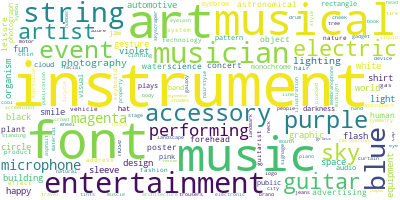

In [126]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Labels'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Finding Ideal Number of Topics

In this approach, we try various topics and look at the maximum topic coherence.

**Topic Coherence**: Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

There are many measures of measuring coherence. **C_v** has been arbitrarily chosen.

1. **C_v measure** is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2. **C_p** is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
3. **C_uci** measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4. **C_umass** is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5. **C_npmi** is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6. **C_a** is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity


#### It seems as if 3 topics is the best option for us as it has high topic coherence and we get diminishing returns going for more topics (and lose explainability)

In [129]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
import nltk
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','company','work','thing','working','one','great','venterra','really','good','lots','day','love'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords_lemma(texts):
    return [[WordNetLemmatizer().lemmatize(word) for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
def detect_stop(texts):
  stops = []
  for doc in texts:
    for word in simple_preprocess(str(doc)):
      if word in stop_words:
        stops.append(word)
  print("Stop words removed", set(stops))

# Removing stop words and lemmatization. Stop words do not make sense. Lemmatization of nouns can make tokens more coherent.
data = df.Labels.values.tolist()
data_words = list(sent_to_words(data))
detect_stop(data_words)
data_words = remove_stopwords_lemma(data_words)

Stop words removed {'and', 'no', 'the', 'in', 'of', 'on'}


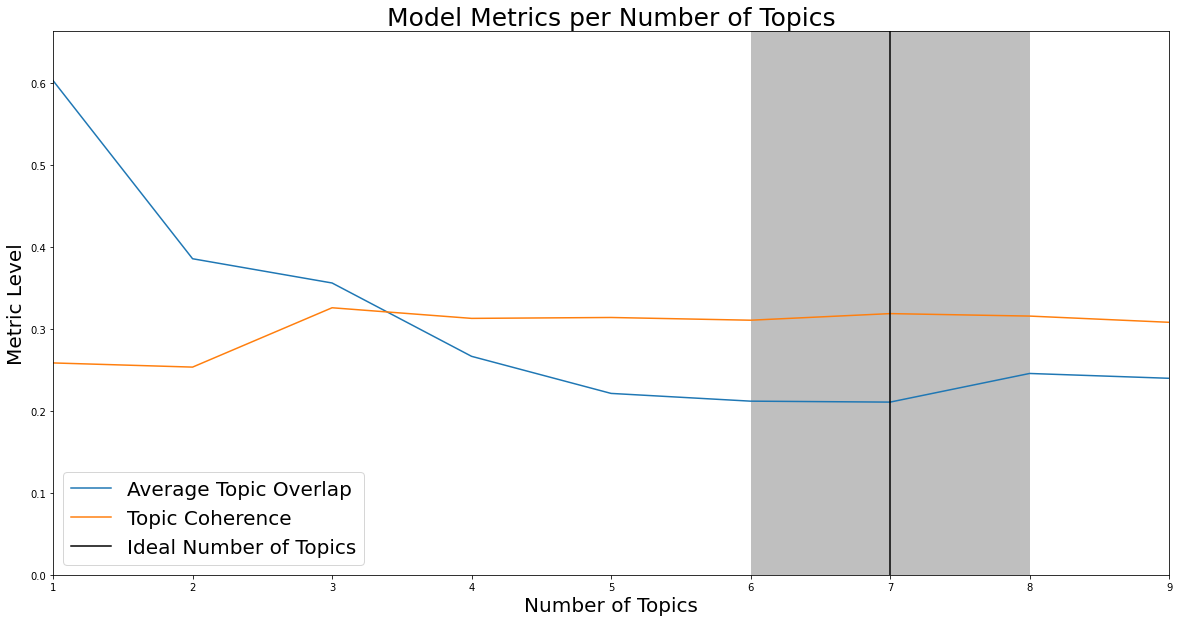

In [133]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# id2word = corpora.Dictionary(data_words)
# corpus = [id2word.doc2bow(text) for text in corpus]
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
# print(corpus[:1][0][:30])

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(11)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i)
    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

def jaccard_similarity(topic_1, topic_2):
  """
  Derives the Jaccard similarity of two topics

  Jaccard similarity:
  - A statistic used for comparing the similarity and diversity of sample sets
  - J(A,B) = (A ∩ B)/(A ∪ B)
  - Goal is low Jaccard scores for coverage of the diverse elements
  """
  intersection = set(topic_1).intersection(set(topic_2))
  union = set(topic_1).union(set(topic_2))
                  
  return float(len(intersection))/float(len(union))

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

coherences = [CoherenceModel(model=LDA_models[i], texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

## Trying Ideal Number of Topics

In [131]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# # View
# print(corpus[:1][0][:30])

In [132]:
from pprint import pprint
# number of topics
num_topics = ideal_topic_num
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.086*"instrument" + 0.052*"musical" + 0.047*"music" + 0.036*"musician" + '
  '0.034*"string" + 0.029*"artist" + 0.028*"accessory" + 0.024*"entertainment" '
  '+ 0.023*"guitar" + 0.018*"microphone"'),
 (1,
  '0.028*"instrument" + 0.024*"musical" + 0.024*"font" + 0.023*"automotive" + '
  '0.022*"design" + 0.017*"art" + 0.017*"musician" + 0.016*"music" + '
  '0.015*"entertainment" + 0.015*"sky"'),
 (2,
  '0.097*"instrument" + 0.069*"string" + 0.043*"guitar" + 0.039*"accessory" + '
  '0.029*"art" + 0.028*"musical" + 0.025*"musician" + 0.018*"music" + '
  '0.017*"font" + 0.017*"guitarist"'),
 (3,
  '0.045*"font" + 0.042*"art" + 0.031*"lighting" + 0.025*"entertainment" + '
  '0.020*"world" + 0.019*"light" + 0.018*"building" + 0.018*"purple" + '
  '0.016*"performing" + 0.014*"landmark"'),
 (4,
  '0.039*"font" + 0.028*"event" + 0.027*"art" + 0.026*"blue" + '
  '0.020*"electric" + 0.020*"entertainment" + 0.018*"darkness" + 0.017*"nose" '
  '+ 0.017*"cheek" + 0.017*"advertising"'),
 (5,

In [12]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word) #, mds='mmds'
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ "ideal_topics_" + str(num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.032789 -0.048185       1        1  25.925194
3     -0.190783  0.033214       2        1  23.841719
1      0.075173 -0.013353       3        1  11.214188
2      0.082681 -0.075252       4        1  10.987296
6     -0.103338 -0.055216       5        1  10.225900
4      0.036550  0.039214       6        1   9.922339
0      0.066928  0.119578       7        1   7.883363, topic_info=            Term        Freq       Total Category  logprob  loglift
17    instrument  250.000000  250.000000  Default  30.0000  30.0000
23        string  109.000000  109.000000  Default  29.0000  29.0000
131    accessory   87.000000   87.000000  Default  28.0000  28.0000
19       musical  142.000000  142.000000  Default  27.0000  27.0000
16        guitar   80.000000   80.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
27         flash    4.715419   44.172646   Topic7  -4.6491   0.3031
17    instrument    6.334205  250.145055   Topic7  -4.3540  -1.1357
83        purple    5.160890   84.468342   Topic7  -4.5588  -0.2549
29   photography    4.802641   57.270314   Topic7  -4.6308   0.0618
114     electric    4.710737   78.850142   Topic7  -4.6501  -0.2773

[500 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
131       1  0.034384  accessory
131       2  0.676214  accessory
131       3  0.011461  accessory
131       5  0.240686  accessory
131       6  0.022923  accessory
...     ...       ...        ...
483       5  0.391945    wrinkle
483       7  0.391945    wrinkle
309       1  0.428387    writing
309       5  0.428387    writing
319       4  0.550233       yoga

[1033 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 3, 7, 5, 1])

## Trying with fewer topics

### 4 Topics

In [140]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [141]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word) #, mds='mmds'
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.091393  0.001002       1        1  33.047942
1      0.057815  0.014344       2        1  29.649189
3      0.020258 -0.076869       3        1  22.642821
0      0.013320  0.061523       4        1  14.660047, topic_info=           Term        Freq       Total Category  logprob  loglift
17   instrument  249.000000  249.000000  Default  30.0000  30.0000
23       string  114.000000  114.000000  Default  29.0000  29.0000
16       guitar   83.000000   83.000000  Default  28.0000  28.0000
131   accessory   89.000000   89.000000  Default  27.0000  27.0000
19      musical  137.000000  137.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
131   accessory    8.636969   89.647731   Topic4  -4.6642  -0.4198
36       design    7.033439   44.727194   Topic4  -4.8696   0.0701
83       purple    7.872372   85.167190   Topic4  -4.7569  -0.4612
90         blue    7.844776   98.240369   Topic4  -4.7604  -0.6075
114    electric    7.506307   82.293485   Topic4  -4.8045  -0.4745

[304 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
131       1  0.156167  accessory
131       2  0.167322  accessory
131       3  0.580048  accessory
131       4  0.100393  accessory
315       3  0.513713     active
...     ...       ...        ...
113       3  0.115409      world
113       4  0.046164      world
483       2  0.709621    wrinkle
309       4  0.881811    writing
319       3  0.513624       yoga

[535 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [143]:
# Top words for our topics
import re
topicsnames = ['T1', 'T2' , 'T3', 'T4']
print("Top words for our topics:\n")
for i, string in lda_model.show_topics(num_words = 25, formatted=True):
  print(f"""{topicsnames[i]}: {re.findall(r'"(.*?)"', string)}""")

Top words for our topics:

T1: ['art', 'font', 'event', 'entertainment', 'instrument', 'music', 'shirt', 'musical', 'smile', 'musician', 'performing', 'artist', 'sleeve', 'guitar', 'microphone', 'happy', 'accessory', 'paper', 'system', 'public', 'purple', 'blue', 'magenta', 'leisure', 'equipment']
T2: ['music', 'entertainment', 'instrument', 'musician', 'musical', 'artist', 'art', 'font', 'microphone', 'performing', 'photography', 'purple', 'black', 'automotive', 'flash', 'event', 'shirt', 'lighting', 'monochrome', 'white', 'forehead', 'human', 'magenta', 'jaw', 'keyboard']
T3: ['font', 'blue', 'art', 'instrument', 'electric', 'string', 'sky', 'event', 'circle', 'world', 'purple', 'organism', 'magenta', 'lighting', 'graphic', 'science', 'object', 'astronomical', 'design', 'music', 'entertainment', 'building', 'space', 'poster', 'advertising']
T4: ['instrument', 'string', 'musical', 'accessory', 'guitar', 'musician', 'music', 'font', 'purple', 'art', 'sky', 'entertainment', 'blue', 'mic

In [117]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
print("Dominant Topic Per Picture Along With Keywords:\n")
display(df_dominant_topic)
df_dominant_topic.to_csv(f'{num_topics}topics_df_dominant_topic.csv')

Dominant Topic Per Picture Along With Keywords:



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9404,"art, font, music, entertainment, artist, blue,...",entertainment magenta visual effect lighting f...
1,1,3.0,0.9547,"instrument, musical, accessory, musician, stri...",footwear musical instrument band plays microph...
2,2,2.0,0.9478,"art, font, music, entertainment, artist, blue,...",flash photography music entertainment music ar...
3,3,2.0,0.9374,"art, font, music, entertainment, artist, blue,...",amber gadget audio equipment automotive design...
4,4,1.0,0.9575,"instrument, musical, string, font, guitar, mus...",bicycle tire wheel bicycles--equipment and sup...
...,...,...,...,...,...
496,496,3.0,0.9339,"instrument, musical, accessory, musician, stri...",shirt shoulder muscle t-shirt vest shorts spor...
497,497,3.0,0.5520,"instrument, musical, accessory, musician, stri...",muscle automotive design style flash photograp...
498,498,2.0,0.9337,"art, font, music, entertainment, artist, blue,...",hand arm musician interaction t-shirt fun even...
499,499,3.0,0.9484,"instrument, musical, accessory, musician, stri...",band plays musical instrument membranophone mi...


In [118]:
def get_proportions(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_df.index = range(lda_model.num_topics)

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topics = pd.DataFrame(row)
        topics.columns = ['Topic', 'Proportion']
        topics.set_index(['Topic'], drop=True, inplace=True)
        sent_topics_df = pd.merge(sent_topics_df, topics, left_index=True, right_index=True)
    
    sent_topics_df.index = ['Topic_' + str(i) for i in sent_topics_df.index]
    sent_topics_df = sent_topics_df.transpose()
    sent_topics_df.reset_index(inplace=True, drop=True)
    return(sent_topics_df)

topic_proportions = get_proportions(ldamodel=lda_model, corpus=corpus, texts=data)
topic_proportions = pd.merge(df, topic_proportions, left_index=True, right_index=True)
display(topic_proportions)
topic_proportions.to_csv('4topics_proportion.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Proportion_x'} in the result is deprecated and will raise a MergeError in a future version.
  if sys.path[0] == '':


,URL,Labels,Comments,Topic_0,Topic_1,Topic_2,Topic_3
1,https://scontent-lga3-1.cdninstagram.com/v/t51...,entertainment magenta visual effect lighting f...,2701.0,0.014749,0.015546,0.014962,0.954743
2,https://scontent-lga3-1.cdninstagram.com/v/t51...,footwear musical instrument band plays microph...,1931.0,0.017032,0.017296,0.947800,0.017872
3,https://scontent-lga3-1.cdninstagram.com/v/t51...,flash photography music entertainment music ar...,2426.0,0.020180,0.021394,0.937437,0.020989
4,https://scontent-lga3-1.cdninstagram.com/v/t51...,amber gadget audio equipment automotive design...,2947.0,0.014075,0.957492,0.014151,0.014283
5,https://scontent-lga3-1.cdninstagram.com/v/t51...,bicycle tire wheel bicycles--equipment and sup...,3083.0,0.284026,0.444284,0.251863,0.019827
...,...,...,...,...,...,...,...
496,https://scontent-lga3-1.cdninstagram.com/v/t51...,cloud sky daytime car infrastructure billboard...,1436.0,0.021733,0.021682,0.022652,0.933933
497,https://scontent-lga3-1.cdninstagram.com/v/t51...,shirt shoulder muscle t-shirt vest shorts spor...,1352.0,0.015952,0.415679,0.016388,0.551980
498,https://scontent-lga3-1.cdninstagram.com/v/t51...,muscle automotive design style flash photograp...,1073.0,0.021241,0.023163,0.933685,0.021911
499,https://scontent-lga3-1.cdninstagram.com/v/t51...,hand arm musician interaction t-shirt fun even...,4195.0,0.016704,0.018060,0.016836,0.948400


### 3 Topics

In [144]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [145]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word) #, mds='mmds'
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str() +'.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002907 -0.041050       1        1  37.249423
2     -0.092648  0.019544       2        1  32.245685
1      0.089742  0.021506       3        1  30.504893, topic_info=           Term        Freq       Total Category  logprob  loglift
17   instrument  226.000000  226.000000  Default  30.0000  30.0000
23       string  102.000000  102.000000  Default  29.0000  29.0000
19      musical  126.000000  126.000000  Default  28.0000  28.0000
131   accessory   81.000000   81.000000  Default  27.0000  27.0000
16       guitar   75.000000   75.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
113       world   12.157043   44.161562   Topic3  -5.0551  -0.1027
3         event   13.324850   88.649210   Topic3  -4.9634  -0.7078
61        black   11.868172   48.873714   Topic3  -5.0792  -0.2281
25          art   12.777065  159.405138   Topic3  -5.0054  -1.3365
18   microphone   11.934732   59.700123   Topic3  -5.0736  -0.4226

[227 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
131       1  0.283887   accessory
131       2  0.024686   accessory
131       3  0.678860   accessory
208       1  0.143464  adaptation
208       2  0.860783  adaptation
...     ...       ...         ...
127       3  0.309491       white
463       3  0.754402  whiteboard
113       1  0.249085       world
113       2  0.475527       world
113       3  0.271730       world

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

#### Top 25 Keywords and Topic Names

In [204]:
# Top words for our topics
import re
topicsnames = ['Music & Artist' , 'Musical Instruments', 'Photography, Graphics & Art']
print("Top words for our topics:\n")
for i, string in lda_model.show_topics(num_words = 25, formatted=True):
  print(f"""{topicsnames[i]}: {re.findall(r'"(.*?)"', string)}""")
print("\nReasons for naming:\nTopic 0 has dominant mentions of music, art, entertainment and colors.")
print("Topic 1 has words related to music, musical instruments, accessories & guitars")
print("Topic 2 has words related to art, fonts, events, photography & lighting.")

Top words for our topics:

Music & Artist: ['music', 'art', 'instrument', 'musician', 'font', 'entertainment', 'artist', 'musical', 'purple', 'blue', 'microphone', 'electric', 'performing', 'magenta', 'event', 'lighting', 'guitar', 'sky', 'accessory', 'string', 'automotive', 'concert', 'light', 'violet', 'organism']
Musical Instruments: ['instrument', 'string', 'musical', 'accessory', 'guitar', 'font', 'musician', 'music', 'blue', 'sky', 'electric', 'entertainment', 'band', 'play', 'rectangle', 'white', 'design', 'product', 'guitarist', 'drum', 'automotive', 'event', 'art', 'happy', 'membranophone']
Photography, Graphics & Art: ['art', 'font', 'event', 'entertainment', 'music', 'photography', 'sky', 'shirt', 'flash', 'happy', 'sleeve', 'performing', 'black', 'lighting', 'gesture', 'world', 'electric', 'blue', 'purple', 'smile', 'forehead', 'magenta', 'eyebrow', 'fun', 'jaw']

Reasons for naming:
Topic 0 has dominant mentions of music, art, entertainment and colors.
Topic 1 has words re

######## Dominant Topic Per Post and Keywords

In [162]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
print("Dominant Topic Per Picture Along With Keywords:\n")
display(df_dominant_topic)
df_dominant_topic.to_csv(f'{num_topics}topics_df_dominant_topic.csv')

Dominant Topic Per Picture Along With Keywords:



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9423,"music, art, instrument, musician, font, entert...",entertainment magenta visual effect lighting f...
1,1,1.0,0.9574,"instrument, string, musical, accessory, guitar...",footwear musical instrument band plays microph...
2,2,0.0,0.9466,"music, art, instrument, musician, font, entert...",flash photography music entertainment music ar...
3,3,0.0,0.9306,"music, art, instrument, musician, font, entert...",amber gadget audio equipment automotive design...
4,4,1.0,0.9610,"instrument, string, musical, accessory, guitar...",bicycle tire wheel bicycles--equipment and sup...
...,...,...,...,...,...
496,496,2.0,0.9410,"art, font, event, entertainment, music, photog...",shirt shoulder muscle t-shirt vest shorts spor...
497,497,2.0,0.9488,"art, font, event, entertainment, music, photog...",muscle automotive design style flash photograp...
498,498,1.0,0.9298,"instrument, string, musical, accessory, guitar...",hand arm musician interaction t-shirt fun even...
499,499,1.0,0.9530,"instrument, string, musical, accessory, guitar...",band plays musical instrument membranophone mi...


#### Differences in the average topic weights of images across the best and worst quartiles

In [163]:
def get_proportions(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_df.index = range(lda_model.num_topics)

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topics = pd.DataFrame(row)
        topics.columns = ['Topic', 'Proportion']
        topics.set_index(['Topic'], drop=True, inplace=True)
        sent_topics_df = pd.merge(sent_topics_df, topics, left_index=True, right_index=True)
    
    sent_topics_df.index = ['Topic_' + str(i) for i in sent_topics_df.index]
    sent_topics_df = sent_topics_df.transpose()
    sent_topics_df.reset_index(inplace=True, drop=True)
    return(sent_topics_df)

topic_proportions = get_proportions(ldamodel=lda_model, corpus=corpus, texts=data)
topic_proportions = pd.merge(df, topic_proportions, left_index=True, right_index=True)
display(topic_proportions)
topic_proportions.to_csv(f'{num_topics}topics_proportion.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Proportion_x'} in the result is deprecated and will raise a MergeError in a future version.
  if sys.path[0] == '':


,URL,Labels,Comments,Percentile,Topic_0,Topic_1,Topic_2
0,https://scontent-lga3-1.cdninstagram.com/v/t51...,entertainment magenta visual effect lighting f...,2701.0,0.744511,0.942273,0.027641,0.030086
1,https://scontent-lga3-1.cdninstagram.com/v/t51...,footwear musical instrument band plays microph...,1931.0,0.644711,0.022591,0.957425,0.019984
2,https://scontent-lga3-1.cdninstagram.com/v/t51...,flash photography music entertainment music ar...,2426.0,0.706587,0.946628,0.023724,0.029647
3,https://scontent-lga3-1.cdninstagram.com/v/t51...,amber gadget audio equipment automotive design...,2947.0,0.766467,0.930577,0.035146,0.034276
4,https://scontent-lga3-1.cdninstagram.com/v/t51...,bicycle tire wheel bicycles--equipment and sup...,3083.0,0.780439,0.019558,0.960962,0.019479
...,...,...,...,...,...,...,...
496,https://scontent-lga3-1.cdninstagram.com/v/t51...,shirt shoulder muscle t-shirt vest shorts spor...,1352.0,0.568862,0.029691,0.029270,0.941039
497,https://scontent-lga3-1.cdninstagram.com/v/t51...,muscle automotive design style flash photograp...,1073.0,0.473054,0.026315,0.024819,0.948866
498,https://scontent-lga3-1.cdninstagram.com/v/t51...,hand arm musician interaction t-shirt fun even...,4195.0,0.844311,0.033419,0.929749,0.036832
499,https://scontent-lga3-1.cdninstagram.com/v/t51...,band plays musical instrument membranophone mi...,824.0,0.359281,0.024557,0.953007,0.022436


In [221]:
q1 = topic_proportions[['Topic_0', 'Topic_1', 'Topic_2']][(topic_proportions.Percentile<0.25)].mean()
q4 = topic_proportions[['Topic_0', 'Topic_1', 'Topic_2']][(topic_proportions.Percentile>0.75)].mean()
results = pd.concat([q1, q4], axis=1)
results.columns = ['Lowest Quartile', 'Highest Quartile']
results.index = topicsnames
display(results)
print(f'\nAverage Topic Weights shown for Worst and Best Quartiles of Posts')
print("""\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------------
We notice that for the lowest quartile of posts, more than a third of the posts are related to topics that are mostly related to art and photography. 
This means that Coldplay got less engagement for posts that were primarily described as artistic (including lots of graphics, lights, fonts).

For the high engagement posts, the most dominant topic is Music & Artist which contains images of musicians and their instruments. 
These posts also are fewer related to the Musical Instruments topic, which means that high performing posts did not show musical instruments on their own.
Perhaps, highest engagement came when the pictures contained both the Musician and them performing their art (music and musical instruments).
""")

,Lowest Quartile,Highest Quartile
Music & Artist,0.308436,0.430156
Musical Instruments,0.312864,0.232107
"Photography, Graphics & Art",0.378700,0.337737



Average Topic Weights shown for Worst and Best Quartiles of Posts



---------------------------------------------------------------------------------------------------------------------------------------------------------
We notice that for the lowest quartile of posts, more than a third of the posts are related to topics that are mostly related to art and photography. 
This means that Coldplay got less engagement for posts that were primarily described as artistic (including lots of graphics, lights, fonts).

For the high engagement posts, the most dominant topic is Music & Artist which contains images of musicians and their instruments. 
These posts also are fewer related to the Musical Instruments topic, which means that high performing posts did not show musical instruments on their own.
Perhaps, highest engagement came when the pictures contained both the Musician and them performing their art (music and musical instruments).



# Task B: Advice to the company 

What advice would you give the company if it wants to increase engagement on its Instagram page based on your findings?

---------------------------------

We have 3 dominant topics in our images:

1.   Music & Arists
2.   Musical Instruments
3.   Photography, Graphics & Art


Looking at the highest and lowest quartiles of posts in terms of engagement, we find that the most popular posts have the highest concentration of topic 1. Lowest performing posts have higher contributionsf of topics 2 & 3.

We would suggest that Coldplay focus on **posting more pictures that contain the performing artists. Posts should show that they are playing music and entertaining people. These can include fancy lights, fonts and graphics, pictures taken at concerts under the sky as they have performed well. Colors like Blue and Violet are also dominant in these pictures and work well with the theme of the band.**

These recommendations are based on what has worked well for Coldplay in the past (common themes in posts that got highest engagement) and further causal analysis should be made to ascertain if engagement is not caused by other factors e.g temporal heterogeneity.



